# Changepoint Detection with Bayesian Inferenec - SPPT Example

Basic idea: look for a point where the global S value stops changing (i.e. becomes reasomably constant). This could be the point at which the resolution is 'optimal'

See the acompanying `spatial_resolution*.Rmd' for information about how the index was calculated.

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import interp1d
import statsmodels.api as sm
from IPython.core.pylabtools import figsize
import feather

import pymc3 as pm
import theano.tensor as tt

%matplotlib inline

## Data

Read the data (this was created by the `spatial_resolution*.Rmd` script)

In [214]:
data = feather.read_dataframe("./bner_results.feather")
#num_cells = data.loc[:,['num.cells']].values
num_cells = data['num.cells'].tolist()
global_s  = data['global_s' ].tolist()
iteration = data['iteration'].tolist()

# Caculate difference from one iteration to the next. This is what we actually want to model. 
# (Also Keep track of the iteration number associated with each difference)
mean = []
mean.append(0)
difference = []
difference.append(0)
current = int(iteration[0])
_sum = 0 # to calculate the mean S value per iteration
for i in range(len(num_cells)):   

    if iteration[int(i)] != current:  # Detect the next iteration
        _mean = _sum / float(len(data.loc[data['iteration'] == current])) # Mean error for this iteration
        diff = _mean - mean[-1] # Difference is current mean minus the previous one
        mean.append(_mean) # Remember the current mean for next time
        difference.append(diff)
        _sum = 0
        current = int(iteration[i])
    
    _sum += global_s[i]

# Drop the first values as we need at least 2 datapoints to calcuate the difference
difference = difference[1:]
mean = mean[1:]
    
# Sanity check
assert len(mean) == len(difference)

In [92]:
# The difference is basically constant after the first few iterations. Try cutting off the older data to see what happens
#difference = difference[0:30]

Plot them

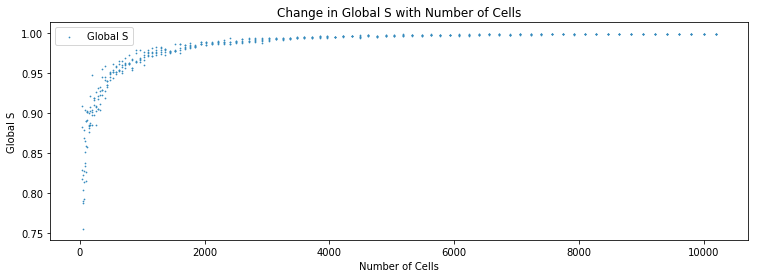

In [215]:
figsize(12.5, 4)
plt.scatter(num_cells[20:], global_s[20:], color="#348ABD", label="Global S", marker=".", s=2) 
plt.xlabel("Number of Cells")
plt.ylabel("Global S")
plt.title("Change in Global S with Number of Cells")
plt.legend()

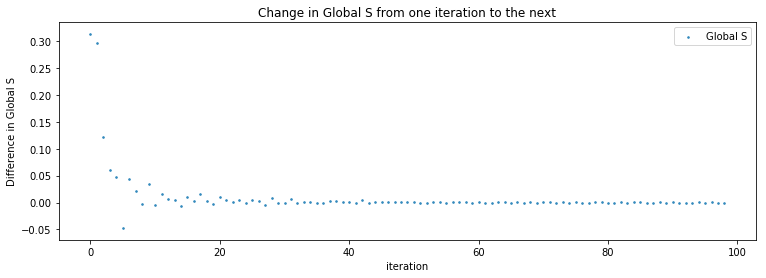

In [216]:
figsize(12.5, 4)
plt.scatter(np.arange(len(difference)), difference, color="#348ABD", label="Global S", marker=".", s=10) 
plt.xlabel("iteration")
plt.ylabel("Difference in Global S")
plt.title("Change in Global S from one iteration to the next")
plt.legend()

## Model Conception

We want to model the chance in Global S value. This is continuous and must be positive, so use an exponential distribution:

$$Z \sim \text{Exp}(\lambda)$$


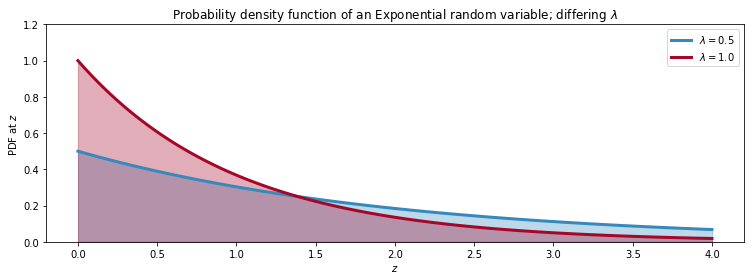

In [66]:
colours = ["#348ABD", "#A60628"]
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

We assume that the value of $\lambda$ changes at some point, called $\tau$, so in factt there are two $\lambda$ parameters, one before $\tau$ and one afterwards:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

We also need to assign prior probabilities to the different possible values of $\lambda$. As this can be any positive number, use an  *exponential* distribution. This takes it's own parameter, $\alpha$ and $\beta$: (a *hyper parameters*)

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \beta )
\end{align}

## Model Definition

Now define the model using PYMC. (_Note that we use the same values for the hyperparameters, although above I talked about them as separate variables for each of the two Normal distributions_).

In [108]:
with pm.Model() as model:
    # The hyperparameters (apparently good to chose the mean of the observations as a starting point)
    alpha = 1.0/pd.Series(difference).mean()
    beta  = 1.0/pd.Series(difference).mean()

    # The two lambda parameters. (We want to see if their posterior distributions change)
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", beta)
    
    # Tau is the point at which the texting behaviour changed. We don't know anything about this 
    # so we assign a uniform prior belief
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(difference) - 1)
    
    idx = np.arange(len(difference)) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    # The observations
    observation = pm.Poisson("obs", lambda_, observed=difference)

The model has been defined, now we can perform MCMC to sample from the posterior distribution

In [118]:
N = 10000 # Number of samples
with model:
    step = pm.Metropolis()
    start = pm.find_MAP() # Help it to start from a good place
    trace = pm.sample(N, tune=int(N*2), step=step, start=start, njobs=8)

logp = 4.5949, ||grad|| = 0.0014211: 100%|██████████| 19/19 [00:00<00:00, 1751.78it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
100%|██████████| 30000/30000 [00:14<00:00, 2042.47it/s]
The number of effective samples is smaller than 25% for some parameters.


The model has finished. Now example our samples.

Begin with a default plot provided by pymc

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137ea9668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13af8c390>]], dtype=object)

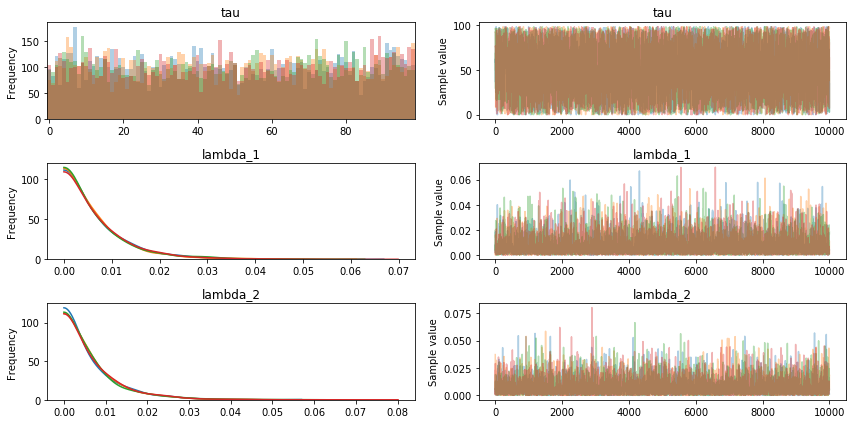

In [119]:
#pm.plots.traceplot(trace=trace, varnames=["lambda_1", "lambda_2", "tau"])
pm.plots.traceplot(trace=trace)

Some bespoke plots.  These mostly just confirm what we suspected

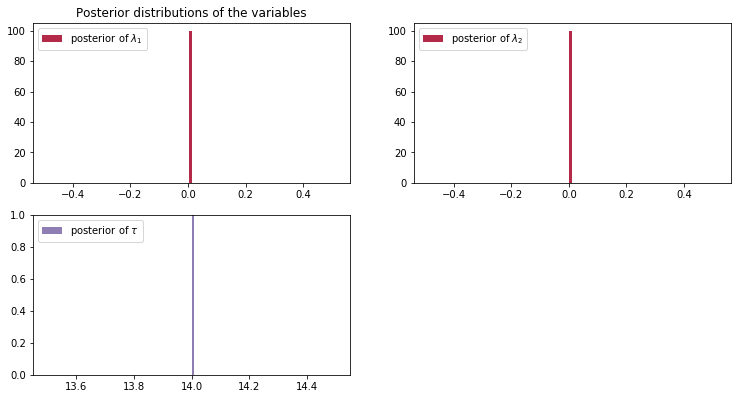

In [194]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

figsize(12.5, 10)
#histogram of the samples:

# Lambdas

ax = plt.subplot(321) # rows, columns, index
ax.set_autoscaley_on(True)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables""")
#plt.xlim([15, 30])
#plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(322) # rows, columns, index
ax.set_autoscaley_on(True)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_2$", color="#A60628", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
#plt.xlabel("$\lambda_1$ value")


# TAU
ax = plt.subplot(323)
ax.set_autoscaley_on(False)
plt.hist(tau_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label=r"posterior of $\tau$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
#plt.xlabel(r"$\tau$ value")


Some more diagnostic visualisations

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12729a9b0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12caab6d8>], dtype=object)

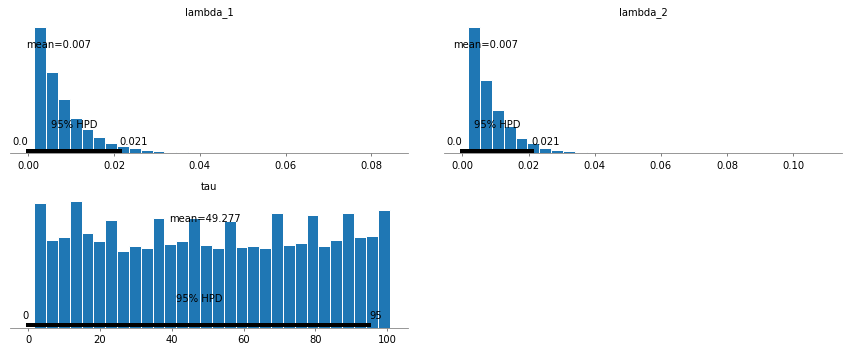

In [90]:
pm.plots.plot_posterior(trace=trace, varnames=["lambda_1", "lambda_2", "tau"])
#pm.plots.plot_posterior(trace=trace["centers"][:,1])
#pm.plots.autocorrplot(trace=trace, varnames=["centers"]);

## Sumary / Next steps:

This isnt particularly useful. $\tau$ is all over the place, and the $\lambda$ distributions are the same.

Some more samples at lower iterations might help to make the change more consistent. It jumps around a fair bit at the moment. 

## Lowess model

Create a loess model to try to capture the change in difference. The idea is that I could then is this to create more sample points and this might make it easier to fit a Bayesian model. 

Code from: https://stackoverflow.com/questions/36252434/predicting-on-new-data-using-locally-weighted-regression-loess-lowess

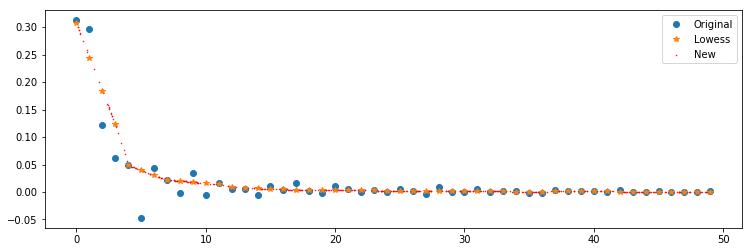

In [251]:
difference=difference[0:50]

# lowess will return our "smoothed" data with a y value for at every x-value
y = difference
x = np.arange(len(difference))
lowess = sm.nonparametric.lowess(y, x, frac=.18)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = sorted([random.uniform(0,len(difference)) for r in range(500)])

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)


plt.plot(x, y, 'o', label="Original")
plt.plot(lowess_x, lowess_y, '*', label="Lowess")
plt.scatter(xnew, ynew, marker='.', color="#FF0000", label="New", s=1)
plt.legend()
plt.show()

In [252]:
with pm.Model() as model2:
    alpha = 1.0/pd.Series(ynew).mean()
    beta  = 1.0/pd.Series(ynew).mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", beta)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(difference) - 1)
    
#    idx = np.arange(len(ynew)) # Index
    idx = np.linspace(start=0, stop=len(difference), num=len(ynew)) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    # The observations
    observation = pm.Poisson("obs", lambda_, observed=ynew)

In [253]:
N = 10000 # Number of samples
with model2:
    step = pm.Metropolis()
    start = pm.find_MAP() # Help it to start from a good place
    trace = pm.sample(N, tune=int(N*2), step=step, start=start, njobs=8)

logp = -inf, ||grad|| = 5.1678: 100%|██████████| 3/3 [00:00<00:00, 835.19it/s]
Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
100%|██████████| 30000/30000 [00:16<00:00, 1805.82it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137cc0780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1402e7cc0>]], dtype=object)

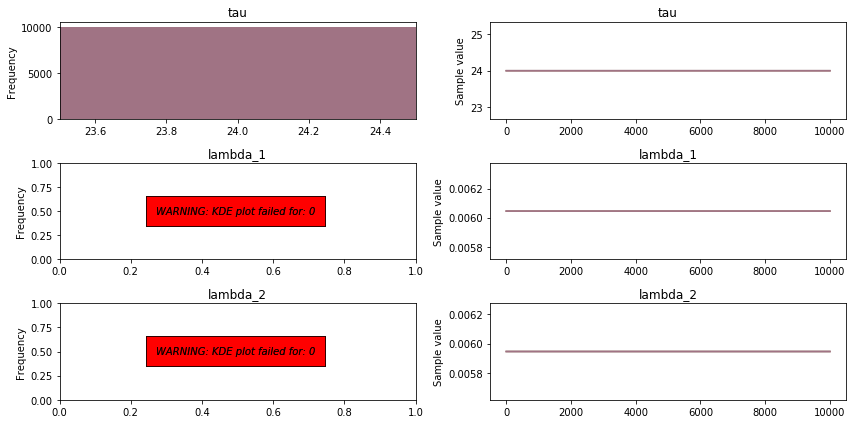

In [254]:
pm.plots.traceplot(trace=trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14099d9b0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x137e89f60>], dtype=object)

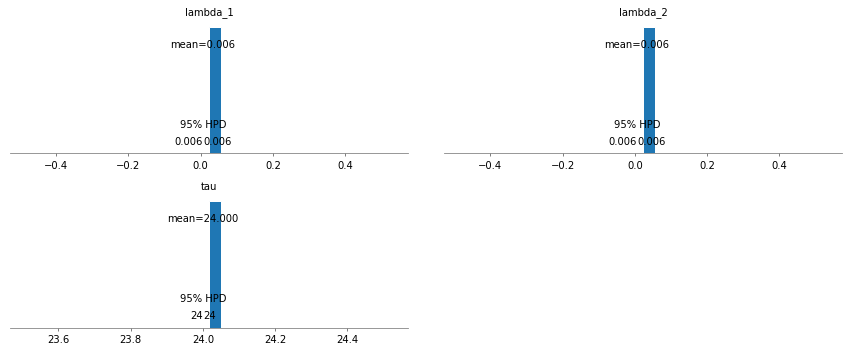

In [255]:
pm.plots.plot_posterior(trace=trace, varnames=["lambda_1", "lambda_2", "tau"])

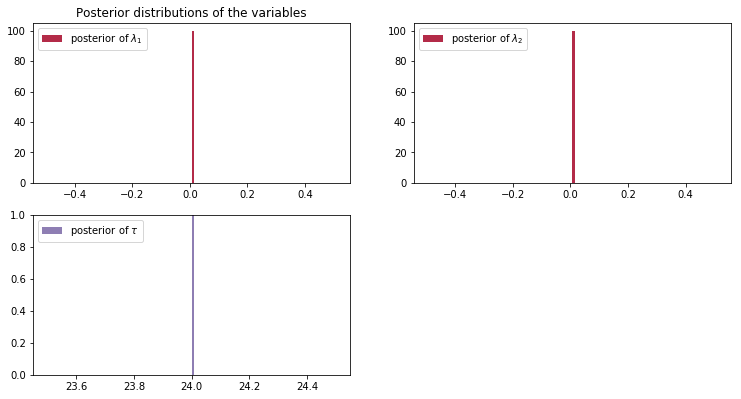

In [256]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

figsize(12.5, 10)
#histogram of the samples:

# Lambdas

ax = plt.subplot(321) # rows, columns, index
ax.set_autoscaley_on(True)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables""")
#plt.xlim([15, 30])
#plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(322) # rows, columns, index
ax.set_autoscaley_on(True)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_2$", color="#A60628", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
#plt.xlabel("$\lambda_1$ value")


# TAU
ax = plt.subplot(323)
ax.set_autoscaley_on(False)
plt.hist(tau_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label=r"posterior of $\tau$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
#plt.xlabel(r"$\tau$ value")
